# Importing libraries

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from bertopic import BERTopic
from bertopic.representation import TextGeneration
from git_root import git_root
from hdbscan import HDBSCAN
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import BitsAndBytesConfig
from umap import UMAP

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
my_git_root = git_root()
sys.path.append(my_git_root)
from src import *

# Loading the data

In [2]:
df_documents_path = f'{my_git_root}/data/output/documents_chunked_structured.csv'
df_documents = pd.read_csv(df_documents_path)

In [3]:
df_documents

,name,text,num_tokens
0,aalto-university.md,Aalto University,3
1,aalto-university.md,Aalto University Research Data Management Policy,7
2,aalto-university.md,The research data management policy aims to ma...,89
3,aalto-university.md,The data management policy shall be implemente...,104
4,aalto-university.md,Ownership of copyright protected research data...,77
...,...,...,...
3481,wrexham-university.md,"FAIR Data\n\nWhere it is lawful to do so, the ...",96
3482,wrexham-university.md,Prifysgol Wrecsam Wrexham University\n\nPublic...,80
3483,wrexham-university.md,Reporting a Data Incident/Breach\n\nThe UK GDP...,125
3484,wrexham-university.md,"Other Polices, Procedures, Legislation\n\nThis...",51


In [4]:
documents = df_documents['text'].to_list()
documents = [document.lower() for document in documents]

In [5]:
def keep_text_only(text):
    return re.sub(r'[^A-Za-z ]', '', text)

In [6]:
documents = [keep_text_only(document) for document in documents]

# Topic Modelling

Initialize text embeddings

In [7]:
embedding_model = SentenceTransformer('thenlper/gte-small', trust_remote_code=True)

embeddings = embedding_model.encode(documents)

Insert parameters from optimized harmonic mean

In [8]:
umap_parameters = {
    'n_neighbors': 52,
    'n_components': 5,
    'min_dist': 0.7654024396138743,
    'metric': 'cosine',
    'random_state': 42
}

umap_model = UMAP(**umap_parameters)

hdbscan_parameters = {
    'min_cluster_size': 5,
    'min_samples': 5,
}

hdbscan_model = HDBSCAN(**hdbscan_parameters)

bertopic_parameters = {
    'top_n_words': 25,
    'n_gram_range': (2, 5),
    'umap_model': umap_model,
    'hdbscan_model': hdbscan_model
}

In [9]:
bertopic_parameters = {
    'top_n_words': 25,
    'n_gram_range': (2, 4),
    'umap_model': umap_model,
    'hdbscan_model': hdbscan_model,
    'verbose': True
}

In [10]:
topic_model = BERTopic(**bertopic_parameters)
topics, probs = topic_model.fit_transform(documents, embeddings)

2025-02-28 09:27:30,376 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-28 09:27:48,881 - BERTopic - Dimensionality - Completed ✓
2025-02-28 09:27:48,882 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-28 09:27:48,963 - BERTopic - Cluster - Completed ✓
2025-02-28 09:27:48,965 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-28 09:27:50,148 - BERTopic - Representation - Completed ✓


In [11]:
df_document_info = topic_model.get_document_info(documents)

In [12]:
df_document_info['Document_Name'] = df_documents['name']

# Displaying the number of chunks per topic

In [13]:
topic_counts = df_document_info['Topic'].value_counts()
topic_counts.sort_index(inplace=True)

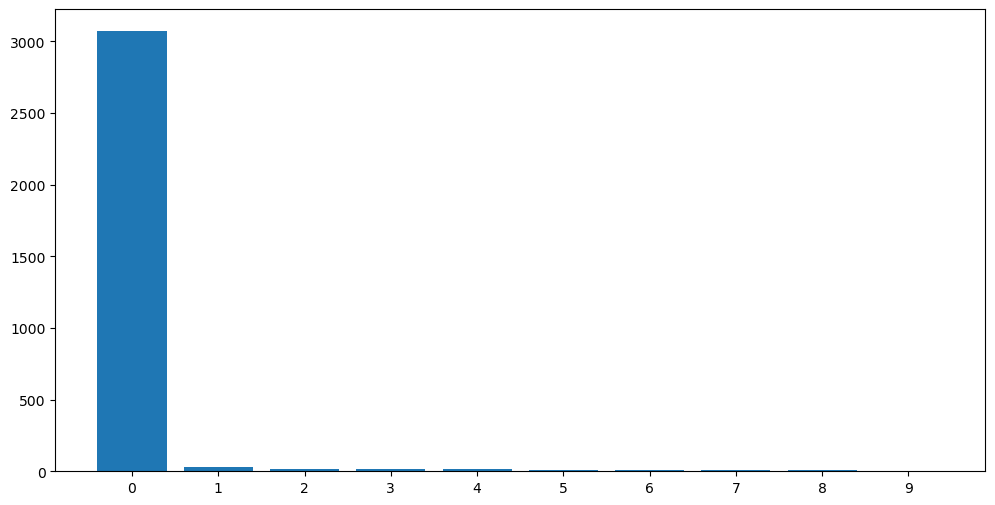

In [14]:
topic_indices = np.arange(0, len(topic_counts) - 1, 1)
topic_counts_graph = [topic_counts[i] for i in topic_indices]

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x=topic_indices, height=topic_counts_graph)
ax.set_xticks(topic_indices)
plt.savefig(f'{my_git_root}/notebooks/model_results/images/bertopic_pre_processed_harmonic_mean_topic_counts.svg')
plt.show()

How much noise is there?

In [15]:
topic_counts[-1]*100/3486

8.663224325874928

How large is the outlier topic?

In [16]:
topic_counts[0]*100/3486

88.0952380952381

What is the mean topic size?

In [17]:
np.mean(topic_counts[1:])

318.4

What is the standard deviation of topic size?

In [18]:
np.std(topic_counts[1:])

917.5595021577619

# Updating topic names to be more human-readable

Setting up LLM for topic interpretation

In [19]:
use_4bit = False
use_8bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    load_in_8bit=use_8bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

In [20]:
torch.random.manual_seed(0)
model_id = "tiiuae/Falcon3-7B-Instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda",
    torch_dtype="auto",
    quantization_config=bnb_config,
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=50,
    repetition_penalty=1.1
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda


In [21]:
prompt = """<|system|>You are a helpful, respectful and honest assistant for labeling topics for texts extracted from Research Data Management Policies.</s>
<|user|>
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.</s>
<|assistant|>"""


In [22]:
# Text generation with Zephyr
llm = TextGeneration(pipe, prompt=prompt)
representation_model = {"representation_LLM": llm}

In [23]:
topic_model.update_topics(documents, top_n_words=1500, n_gram_range=(2, 5), representation_model=representation_model)

2025-02-28 09:28:07,986 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
100%|██████████| 11/11 [00:31<00:00,  2.83s/it]


In [24]:
topics_full = topic_model.get_topics()

Load the topic descriptors into an array

In [25]:
interpretable_topic_names = {}

for index, value in topics_full.items():
    interpretable_topic_name = [topic_descriptor for topic_descriptor, probability in value]
    interpretable_topic_names[index] = interpretable_topic_name

Remove stop-words and only show top 25 descriptors

In [26]:
def remove_stop_words(text):
    stop_words = stopwords.words('english')
    regex_stop_words = '|'.join(stop_words)
    result = re.sub(rf'^((?:{regex_stop_words})\s+)+', '', text)
    result = re.sub(rf'(\s+(?:{regex_stop_words}))+$', '', result)
    return result

In [27]:
def remove_single_words(topic_descriptors):
    result = []
    for topic_descriptor in topic_descriptors:
        if bool(re.search('\s+', topic_descriptor)):
            result.append(topic_descriptor)
    return result

In [28]:
def remove_duplicate_words(topic_descriptors):
    result = []

    for topic_descriptor in topic_descriptors:
        if topic_descriptor not in result:
            result.append(topic_descriptor)
    return result

In [29]:
def keep_top_n_topic_descriptors(topic_descriptors, n):
    return topic_descriptors[:n]

In [30]:
n = 10

for index, value in interpretable_topic_names.items():
    interpretable_topics = [remove_stop_words(topic) for topic in value]
    interpretable_topics = remove_single_words(interpretable_topics)
    interpretable_topics = remove_duplicate_words(interpretable_topics)
    interpretable_topics = keep_top_n_topic_descriptors(interpretable_topics, n)
    interpretable_topic_names[index] = interpretable_topics

In [31]:
def get_topic_info(df_document_info, df_topic_info, topic_names):
    for index, topic_name in topic_names.items():
        my_df_document_info = df_document_info[df_document_info['Topic'] == index]
        print(f'Topic: {index}\n')
        print(f'Representation: {", ".join(topic_name)}\n')
        print(f'representation_LLM: {df_topic_info.iloc[index + 1]["representation_LLM"][0]}\n')
        print(f'Chunks:')
        for doc in my_df_document_info['Document'].to_list():
            print(f'\t{doc}\n')
            print('_'*50)

In [32]:
df_topic_info = topic_model.get_topic_info()

Uncomment this to see the topics and chunks

In [33]:
# get_topic_info(df_document_info, df_topic_info, interpretable_topic_names)

In [34]:
# for key, value in interpretable_topic_names.items():
#     topic_id = key
#     ctfidf_representation = value
#     llm_representation = df_topic_info.iloc[key + 1]['representation_LLM']

#     print(f'\\textbf{{Topic {topic_id}}}:\n\n\\noindent\\textbf{{cTF-IDF representation: }}{", ".join(ctfidf_representation)}\n\n\\noindent\\textbf{{LLM representation: }}{llm_representation[0]}\\\\\n\n\\noindent')